<a href="https://colab.research.google.com/github/kk0mtl/computer-vision/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip Aircraft.zip

Archive:  Aircraft.zip
  inflating: test/airliner/00.jpeg   
  inflating: test/airliner/02.jpeg   
  inflating: test/airliner/04.jpeg   
  inflating: test/airliner/14.jpeg   
  inflating: test/airliner/23.jpeg   
  inflating: test/airliner/26.jpeg   
  inflating: test/airliner/37.jpeg   
  inflating: test/airliner/38.jpeg   
  inflating: test/airliner/57.jpeg   
  inflating: test/airliner/63.jpeg   
  inflating: test/airliner/64.jpeg   
  inflating: test/airliner/82.jpeg   
  inflating: test/airliner/88.jpeg   
  inflating: test/airliner/92.jpeg   
  inflating: test/airliner/96.jpeg   
  inflating: test/airliner/97.jpeg   
  inflating: test/airliner/99.jpeg   
  inflating: test/fighter/02.jpeg    
  inflating: test/fighter/09.jpeg    
  inflating: test/fighter/23.jpeg    
  inflating: test/fighter/37.jpeg    
  inflating: test/fighter/46.jpeg    
  inflating: test/fighter/49.jpeg    
  inflating: test/fighter/53.jpeg    
  inflating: test/fighter/61.jpeg    
  inflating: test/fighter/6

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

In [57]:
batch_size = 16
learning_rate = 0.0005
epoch = 15

n_node = 512  # 1024 -> 512 (overfitting 방지)
dropratio = 0.5

imgsize = 256

## Data Loader

In [58]:
img_dir = "/content/drive/MyDrive/Aircraft/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
      transforms.CenterCrop(imgsize * 2),
      transforms.RandomCrop(imgsize),
      transforms.RandomHorizontalFlip(),

      transforms.Resize(imgsize),
      transforms.ToTensor(),
    ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

198


In [59]:
img_dir = "/content/drive/MyDrive/Aircraft/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
      # transforms.Scale(256),
      # transforms.RandomHorizontalFlip(),

      transforms.CenterCrop(size=imgsize),
      transforms.Resize(imgsize),
      transforms.ToTensor(),
    ]))

dev_batch = data.DataLoader(dev_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [60]:
img_dir = "/content/drive/MyDrive/Aircraft/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
      # transforms.Scale(256),
      # transforms.RandomHorizontalFlip(),

      transforms.CenterCrop(size=imgsize),
      transforms.Resize(imgsize),
      transforms.ToTensor(),
    ]))

test_batch = data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [61]:
nclass = len(train_data.classes)
print("# of classes : %d" % nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training : %d, Dev : %d, Test : %d" % (train_data.__len__(),
                                              dev_data.__len__(),
                                              test_data.__len__(),))

# for imgs, labels in train_batch:
#   for j in range(len(imgs)):
#     img = transforms.ToPILImage()(imgs[j])
#     plt.title("label : %d" % labels[j])
#     plt.imshow(img)
#     plt.show()

# of classes : 3
['airliner', 'fighter', 'helicopter']
{'airliner': 0, 'fighter': 1, 'helicopter': 2}
198
Training : 198, Dev : 51, Test : 51


In [50]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['airliner', 'fighter', 'helicopter']
['airliner', 'fighter', 'helicopter']
['airliner', 'fighter', 'helicopter']


## Model

### Pretrained VGG Model

In [62]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
  print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [37]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### Customized Fully Model

In [63]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        self.layer1 = nn.Sequential(
            nn.Linear(8 * base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            nn.Linear(n_node, nclass),
        )

        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self, x):
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

#### Model on GPU

In [64]:
# model = MyVGG()
model = MyVGG().cuda()

for params in model.layer0.parameters():
  params.requires_grad = False

for params in model.layer1.parameters():
  params.requires_grad = True

In [54]:
for name in model.children():
  print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Train

In [65]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

In [66]:
import utils

total_time = 0
disp_step = 10

to_train = True
if(to_train == False):
  netname = "/content/nets/aircraft_vgg19_10.pkl"
  model = torch.load(netname)
else:
  print("3 layers, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
  model.eval()

  # GPU 사용시
  train_batch_cuda = [(img.cuda(), label.cuda()) for img, label in train_batch]
  dev_batch_cuda = [(img.cuda(), label.cuda()) for img, label in dev_batch]
  test_batch_cuda = [(img.cuda(), label.cuda()) for img, label in test_batch]

  train_corr = utils.ComputeCorr(train_batch_cuda, model)
  dev_corr = utils.ComputeCorr(dev_batch_cuda, model)
  test_corr = utils.ComputeCorr(test_batch_cuda, model)
  print("Correct of train : %.2f, dev: %.2f, test : %.2f"
    %(train_corr, dev_corr, test_corr))

  model.train()

  netname = "/content/nets/aircraft_vgg19"

  x_epoch = []
  y_train_err = []
  y_dev_err = []
  y_test_err = []

  x_epoch.append(0)
  y_train_err.append(100.0-train_corr)
  y_dev_err.append(100.0-dev_corr)
  y_test_err.append(100.0-test_corr)

  # # 학습을 재시작할 시
  # netname = "../content/nets/media_pre_vgg19"
  # model = torch.load(netname)

  # # 파라미터 학습 여부 결정
  # for params in model.layer0.parameters():
  #   params.requires_grad = False

  # for params in model.layer1.parameters():
  #   params.requires_grad = True

  # for i in range(34, epoch)

  # 재시작하지 않는다면
  for i in range(epoch):
    start_time = time.time()
    print("%d.." %i)
    for img, label in train_batch:
      # img = Variable(img)
      img = Variable(img).cuda()
      # label = Variable(label)
      label = Variable(label).cuda()

      optimizer.zero_grad()
      output = model(img)
      loss = loss_func(output, label)
      loss.backward()
      optimizer.step()

    end_time = time.time()
    duration = end_time - start_time
    total_time += duration

    if(i % disp_step == 0) or (i == epoch - 1):
      torch.save(model, netname+"_%d.pkl"%i,)
      print("\n[%d/%d] loss: %.3f" %(i, epoch, (loss.cpu()).data.numpy()))

      model.eval()

      # GPU 사용시
      train_batch_cuda = [(img.cuda(), label.cuda()) for img, label in train_batch]
      dev_batch_cuda = [(img.cuda(), label.cuda()) for img, label in dev_batch]
      test_batch_cuda = [(img.cuda(), label.cuda()) for img, label in test_batch]

      train_corr = utils.ComputeCorr(train_batch_cuda, model)
      dev_corr = utils.ComputeCorr(dev_batch_cuda, model)
      test_corr = utils.ComputeCorr(test_batch_cuda, model)
      print("Correct of train : %.2f, dev: %.2f, test : %.2f"
        %(train_corr, dev_corr, test_corr)),
      model.train()
      print("Time : %.2f sec..." %total_time)

      x_epoch.append(i+1)
      y_train_err.append(100.0-train_corr)
      y_dev_err.append(100.0-dev_corr)
      y_test_err.append(100.0-test_corr)
  print("Total time : %.2f sec" %total_time)

3 layers, n_node: 512, dropratio: 0.50
Correct of train : 33.33, dev: 29.41, test : 29.41
0..

[0/15] loss: 0.902
Correct of train : 48.48, dev: 50.98, test : 54.90
Time : 1.61 sec...
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/15] loss: 1.180
Correct of train : 79.80, dev: 92.16, test : 86.27
Time : 18.97 sec...
11..
12..
13..
14..

[14/15] loss: 1.993
Correct of train : 79.80, dev: 94.12, test : 88.24
Time : 25.72 sec...
Total time : 25.72 sec


In [44]:
torch.cuda.empty_cache()

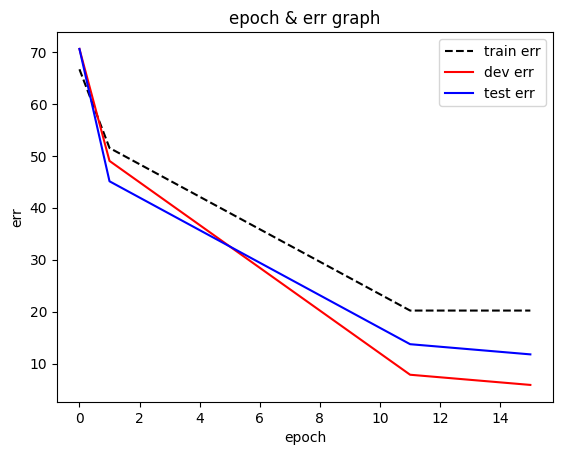

In [67]:
if(to_train):
  plt.plot(x_epoch, y_train_err, color="black", label="train err", linestyle='--')
  plt.plot(x_epoch, y_dev_err, color="red", label="dev err")
  plt.plot(x_epoch, y_test_err, color="blue", label="test err")

  plt.xlabel("epoch")
  plt.ylabel("err")
  plt.title("epoch & err graph")
  plt.legend(loc="upper right")
  plt.show()

Normalized confusion matrix


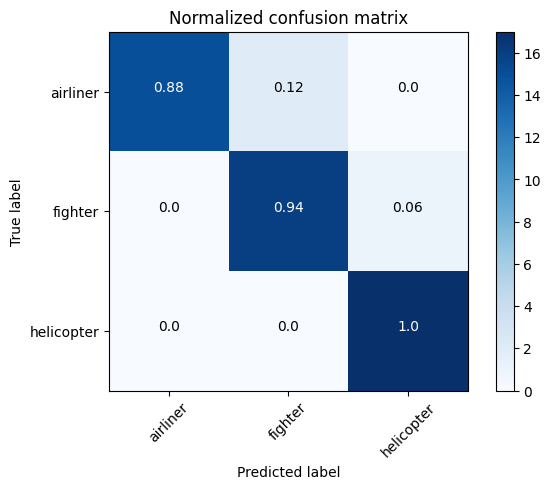

Confusion matrix, without normalization


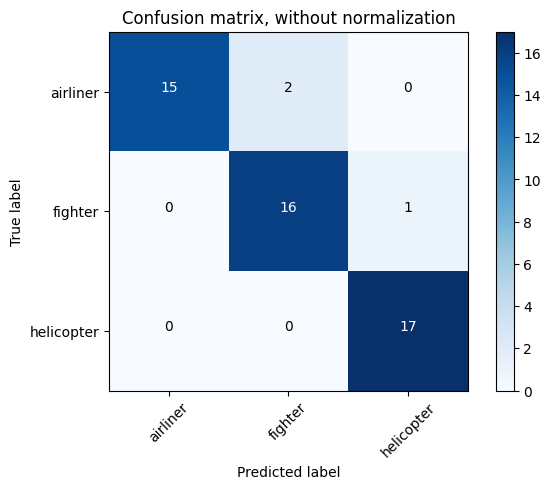

	 acc  |	 pre  |	 rec  |	 f1
 airliner: 0.96 |	 1.00 |	 0.88 |	 0.94
 fighter: 0.94 |	 0.89 |	 0.94 |	 0.91
 helicopter: 0.98 |	 0.94 |	 1.00 |	 0.97
*accuracy: 0.96, precision: 0.94, recall: 0.94, *f1 score: 0.94
[AP]
airliner: 1.00
fighter: 0.98
helicopter: 0.99

[mAP] 0.990
[miAP] 0.980


(array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2]),
 array([0.77701819, 0.97301114, 0.65779114, 0.96328884, 0.99956596,
        0.84904623, 0.61639369, 0.99540931, 0.99800211, 0.48295242,
        0.83017373, 0.53346235, 0.86306977, 0.80081606, 0.99996704,
        0.62515712, 0.56873572, 0.98913944, 0.96618307, 0.89330363,
        0.80997545, 0.79789513, 0.68109608, 0.80850822, 0.97058964,
        0.71603233, 0.91674072, 0.76336575, 0.64979613, 0.96048975,
        0.99106717, 0.73702937, 0.81386685, 0.93781626, 0.96375829,
        0.9283846 , 0.96002483, 0.7286014 , 0.88530338, 0.94909132,
        0.93058461, 0.99975282, 0.90512699, 0.87635064, 0.85781687,
        0.99871522, 0.97020108

In [68]:
model.eval()
dev_batch_cuda = [(img.cuda(), label.cuda()) for img, label in dev_batch]
utils.EvaluateClassifier(dev_batch_cuda, model, dev_data.classes, batch_size)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Normalized confusion matrix


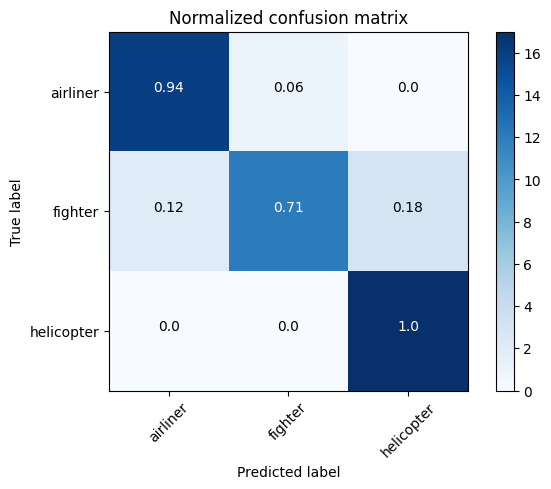

Confusion matrix, without normalization


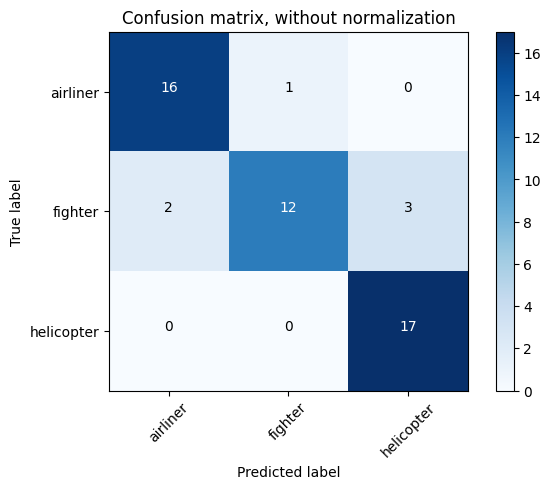

	 acc  |	 pre  |	 rec  |	 f1
 airliner: 0.94 |	 0.89 |	 0.94 |	 0.91
 fighter: 0.88 |	 0.92 |	 0.71 |	 0.80
 helicopter: 0.94 |	 0.85 |	 1.00 |	 0.92
*accuracy: 0.92, precision: 0.89, recall: 0.88, *f1 score: 0.88
[AP]
airliner: 0.93
fighter: 0.91
helicopter: 0.99

[mAP] 0.945
[miAP] 0.961


In [69]:
model.eval()
test_batch_cuda = [(img.cuda(), label.cuda()) for img, label in test_batch]
_, _, _ = utils.EvaluateClassifier(test_batch_cuda, model, test_data.classes, batch_size)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Category: airliner
 True predicted images/total airliner category: 15 / 17
Predicted probability:
[0.7770182  0.16047975 0.06250204]


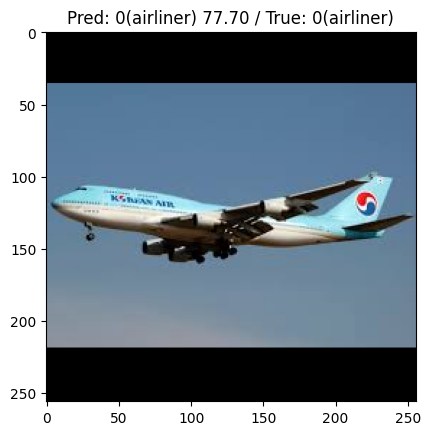

Predicted probability:
[0.97301114 0.02236744 0.0046214 ]


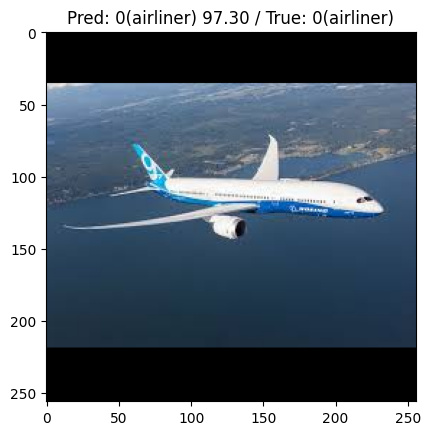

 False predicted images/total airliner category: 2 / 17
Predicted probability:
[0.33453122 0.65779114 0.00767767]


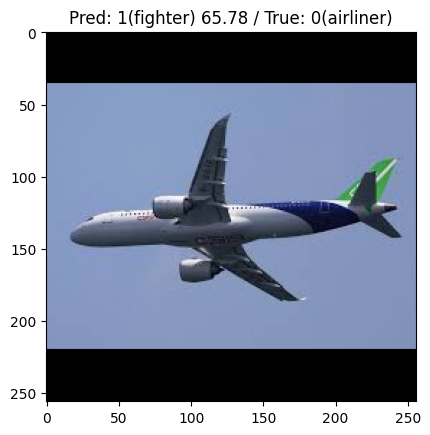

Predicted probability:
[0.2820057  0.6163937  0.10160058]


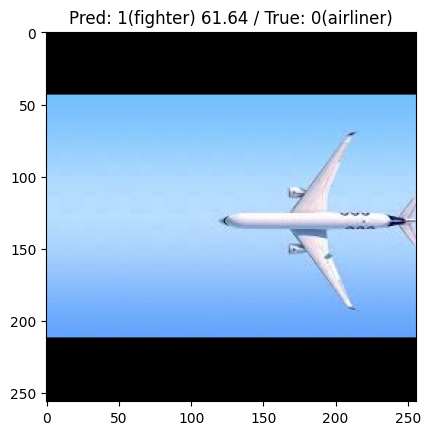

Category: fighter
 True predicted images/total fighter category: 16 / 17
Predicted probability:
[0.0078286  0.98913944 0.00303194]


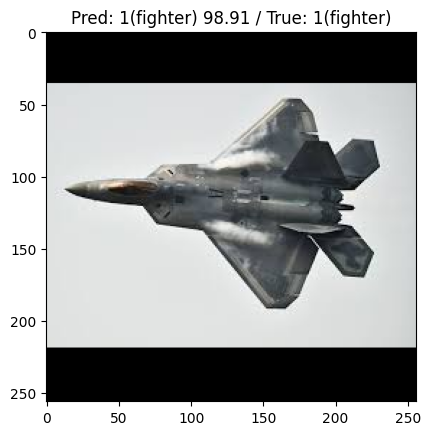

Predicted probability:
[0.03075978 0.96618307 0.00305717]


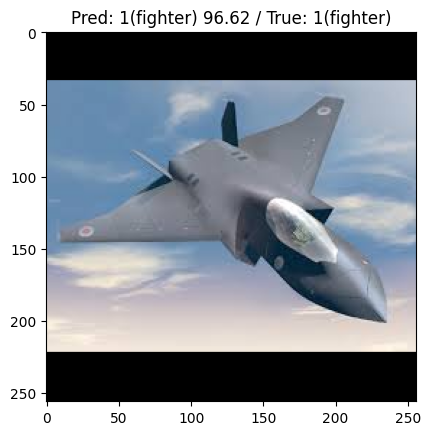

 False predicted images/total fighter category: 1 / 17
Predicted probability:
[0.02324047 0.16289265 0.81386685]


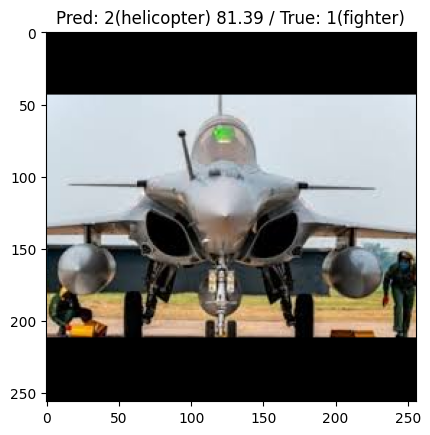

Category: helicopter
 True predicted images/total helicopter category: 17 / 17
Predicted probability:
[0.01094315 0.02529854 0.9637583 ]


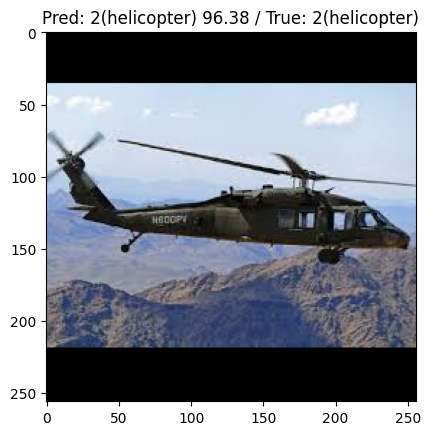

Predicted probability:
[0.01301621 0.0585992  0.9283846 ]


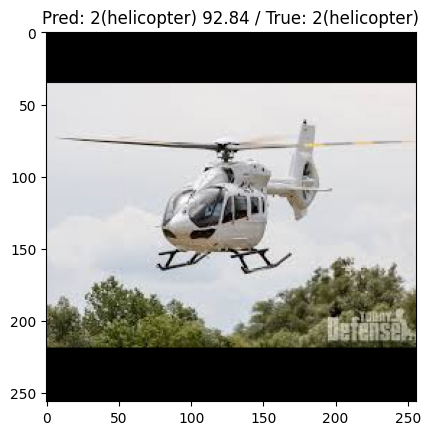

 False predicted images/total helicopter category: 0 / 17


In [70]:
dev_batch_cuda = [(img.cuda(), label.cuda()) for img, label in dev_batch]
utils.VisTFPred(dev_batch_cuda, model, test_data.classes, batch_size, i_n=2)